In [58]:
import numpy as np
import math
import py
import torch
import torch.nn as nn
import torch.nn.functional as F

# A neural network with u_n， θ_c
# u_d = K(θ_c) u_n
# u_d(x) = \int K(x, y, θ_c) u_n(y) dy
class KernelNet(nn.Module):

    def __init__(self, L, Nx, Nθ):
        super(KernelNet, self).__init__()
        self.
        # an affine operation: y = Wx + b
        
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def forward(x):
    return np.sin(x)

In [59]:
# generate data 


k = 5
x_train = np.linspace(-k*math.pi, k*math.pi, 10000).astype(np.float32)
x_test  = np.random.uniform(-k*math.pi, k*math.pi,1000).astype(np.float32)
y_train = forward(x_train)
y_test_ref  = forward(x_test)


x_train = torch.from_numpy(x_train).unsqueeze(-1)
y_train = torch.from_numpy(y_train).unsqueeze(-1)
x_test = torch.from_numpy(x_test).unsqueeze(-1)


In [60]:
# training with adam

model = Net()
loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
for t in range(20000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)
    if t % 100 == 99:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


99 4448.68603515625
199 3877.061767578125
299 3464.06982421875
399 3235.862548828125
499 2940.310546875
599 2380.42919921875
699 1783.0762939453125
799 1407.45361328125
899 1048.7490234375
999 832.8589477539062
1099 585.5537109375
1199 448.4076232910156
1299 385.02264404296875
1399 343.196533203125
1499 326.0893249511719
1599 313.0544128417969
1699 287.41717529296875
1799 274.46844482421875
1899 266.9971008300781
1999 268.06573486328125
2099 252.39048767089844
2199 249.04287719726562
2299 254.54519653320312
2399 244.41392517089844
2499 254.70664978027344
2599 228.8097686767578
2699 225.03756713867188
2799 223.5972137451172
2899 267.9648742675781
2999 213.53326416015625
3099 209.89230346679688
3199 228.96987915039062
3299 202.71141052246094
3399 199.64083862304688
3499 194.81820678710938
3599 191.0471954345703
3699 187.0880889892578
3799 183.28761291503906
3899 181.97705078125
3999 189.1530303955078
4099 170.39480590820312
4199 163.0603790283203
4299 158.30018615722656
4399 153.68359375

In [64]:
# training with BFGS

model = Net()
loss_fn = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8, max_iter=1000, line_search_fn='strong_wolfe')

for t in range(20):    
    def closure():
        optimizer.zero_grad()

        y_pred = model(x_train)

        # Compute and print loss.
        loss = loss_fn(y_pred, y_train)
        
        print(t, loss.item())
        
        loss.backward()
        return loss

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step(closure)
    
    
    
    

0 9533.3935546875
0 6570.12890625
0 5106.3642578125
0 4958.37890625
0 4941.21875
0 4931.78271484375
0 4924.82763671875
0 4914.94970703125
0 4893.72412109375
0 4860.20361328125
0 4846.7275390625
0 4843.173828125
0 4840.240234375
0 4839.318359375
0 4838.1513671875
0 4840.220703125
0 4835.865234375
0 4834.91943359375
0 4831.00634765625
0 4822.19189453125
0 4806.76025390625
0 4803.099609375
0 4777.02392578125
0 4760.16259765625
0 4751.36474609375
0 4710.54443359375
0 8599.2314453125
0 4844.861328125
0 4698.951171875
0 4684.76220703125
0 4655.69384765625
0 4658.9296875
0 4588.501953125
0 4478.568359375
0 4492.4697265625
0 4398.1005859375
0 4315.8955078125
0 4240.31103515625
0 4167.0986328125
0 4094.64892578125
0 4120.56689453125
0 4088.22705078125
0 4062.975830078125
0 4039.912841796875
0 4009.93994140625
0 4090.000732421875
0 3997.809326171875
0 3972.913818359375
0 3925.421875
0 3902.96337890625
0 3866.00048828125
0 3746.088134765625
0 3931.601318359375
0 3715.8076171875
0 3662.1142578125


0 360.60784912109375
0 360.093505859375
0 359.626953125
0 359.2889709472656
0 358.91314697265625
0 358.4544372558594
0 357.7133483886719
0 356.8878173828125
0 355.2675476074219
0 354.2064208984375
0 352.9805603027344
0 351.66448974609375
0 350.2772521972656
0 348.7168273925781
0 347.5032958984375
0 346.4322204589844
0 345.385009765625
0 344.20465087890625
0 343.1117858886719
0 339.8705139160156
0 366.3505554199219
0 334.63079833984375
0 435.3885803222656
0 333.94989013671875
0 331.4134216308594
0 329.4812316894531
0 328.2286071777344
0 327.5982666015625
0 327.02130126953125
0 326.4389953613281
0 325.9893798828125
0 325.7219543457031
0 325.47711181640625
0 325.23199462890625
0 324.8621520996094
0 324.4227294921875
0 324.0066223144531
0 323.7460021972656
0 323.2137145996094
0 322.04180908203125
0 323.89404296875
0 320.59979248046875
0 319.6237487792969
0 317.80413818359375
0 316.5406188964844
0 315.673828125
0 315.0833435058594
0 314.4139404296875
0 313.9022216796875
0 313.28204345703125

0 81.09962463378906
0 80.76375579833984
0 80.62016296386719
0 79.70967102050781
0 79.10665893554688
0 78.57874298095703
0 77.88175201416016
0 77.42618560791016
0 76.9656982421875
0 76.24505615234375
0 75.80878448486328
0 75.36231231689453
0 75.07513427734375
0 74.9168472290039
0 74.65372467041016
0 74.28407287597656
0 73.6680679321289
0 73.00647735595703
0 71.49391174316406
0 69.55998992919922
0 68.1233901977539
0 67.33163452148438
0 66.3087158203125
0 65.32734680175781
0 64.49400329589844
0 63.48672103881836
0 62.640201568603516
0 61.8446159362793
0 61.1492805480957
0 60.60220718383789
0 60.20760726928711
0 59.845909118652344
0 59.364749908447266
0 58.701026916503906
0 57.78080368041992
0 56.392051696777344
0 55.23603439331055
0 54.836151123046875
0 53.94597244262695
0 53.53276062011719
0 53.139503479003906
0 52.21889877319336
0 51.60113525390625
0 50.89467239379883
0 50.538177490234375
0 50.27240753173828
0 49.800785064697266
0 49.13516616821289
0 48.91300582885742
0 48.3675346374511

1 24.2876033782959
1 24.276519775390625
1 24.270689010620117
1 24.266572952270508
1 24.25661849975586
1 24.263626098632812
1 24.250537872314453
1 24.2474422454834
1 24.24428367614746
1 24.24268341064453
1 24.240068435668945
1 24.239179611206055
1 24.23763084411621
1 24.234437942504883
1 24.232223510742188
1 24.231552124023438
1 24.2303466796875
1 24.226587295532227
1 24.229393005371094
1 24.225120544433594
1 24.392812728881836
1 24.22303581237793
1 24.22004508972168
1 24.21601104736328
1 24.212474822998047
1 24.21695327758789
1 24.21200180053711
1 24.20917510986328
1 24.205698013305664
1 24.20413589477539
1 24.203025817871094
1 24.202287673950195
1 24.2004451751709
1 24.199237823486328
1 24.19840431213379
1 24.1948184967041
1 24.192296981811523
1 24.19333839416504
1 24.191320419311523
1 24.188270568847656
1 24.18170166015625
1 24.173742294311523
1 24.16718101501465
1 24.15970230102539
1 24.170631408691406
1 24.15754508972168
1 24.153291702270508
1 24.14653968811035
1 24.13953971862793


1 20.71119499206543
1 20.704288482666016
1 20.70012855529785
1 20.69493865966797
1 20.690776824951172
1 20.684022903442383
1 20.679710388183594
1 20.673934936523438
1 20.66783332824707
1 20.65922737121582
1 20.655393600463867
1 20.65618133544922
1 20.652620315551758
1 20.64748764038086
1 20.643287658691406
1 20.639385223388672
1 20.637203216552734
1 20.635183334350586
1 20.634061813354492
1 20.63477325439453
1 20.633384704589844
1 20.631999969482422
1 20.631990432739258
1 20.63142204284668
1 20.62934112548828
1 20.628326416015625
1 20.6273250579834
1 20.62554931640625
1 20.62323760986328
1 20.620180130004883
1 20.616622924804688
1 20.612268447875977
1 20.603168487548828
1 20.55398941040039
1 20.620750427246094
1 20.544967651367188
1 21.355459213256836
1 20.54136085510254
1 20.512100219726562
1 20.526941299438477
1 20.47920036315918
1 20.478731155395508
1 20.428098678588867
1 20.40418815612793
1 20.385501861572266
1 20.360803604125977
1 20.349044799804688
1 20.329694747924805
1 20.31842

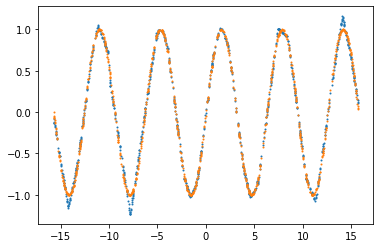

In [65]:
# test

import matplotlib.pyplot as plt

y_test = model(x_test)

plt.plot(x_test.detach().numpy(), y_test.detach().numpy(), "o", markersize=1)
plt.plot(x_test.detach().numpy(), y_test_ref, "o", markersize=1)